## Data Analysis && Traing Dataset Generation 

In [1]:
import numpy as np
import os
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
np.random.seed(0)

In [2]:
# create csv of all images
p = "Places_Data/train_val"

CSVs = []

for city in os.listdir("../"+p):
    for folder in ['query', 'database']:

        path = f"{p}/{city}/{folder}"

        csv = pd.read_csv(f"../{path}/postprocessed.csv",index_col = 1)

        raw = pd.read_csv(f"../{path}/raw.csv",index_col = 1)

        seq = pd.read_csv(f"../{path}/seq_info.csv",index_col = 1)

        csv = csv.merge(raw["pano"].to_frame(),left_index=True,right_index=True).merge(seq,left_index=True,right_index=True)

        csv["Path"] = path

        csv["City"] = city

        csv = csv.reset_index()

        CSVs.append(csv)

df = pd.concat(CSVs)
df.index = range(len(df))



In [3]:
# sequences = df["sequence_key"].unique()
# unique_dicretion = lambda key: len(df.loc[df["sequence_key"]==key,"view_direction"].unique()) == 1

# vals = {sequence: unique_dicretion(sequence) for sequence in tqdm.tqdm(sequences)}
# sq = pd.DataFrame(vals.values(),index=vals.keys())
# sq.columns = ["no_change"]
# suspect = sq[sq["no_change"]==False].index
# wrong = df[df["sequence_key"].apply(lambda x: x in suspect)]
# wrong["City"].unique()  
# wrong = wrong[wrong["pano"]==False]

In [4]:
seq_dif = pd.read_csv("sequences_with_different_directions.csv",index_col=0)

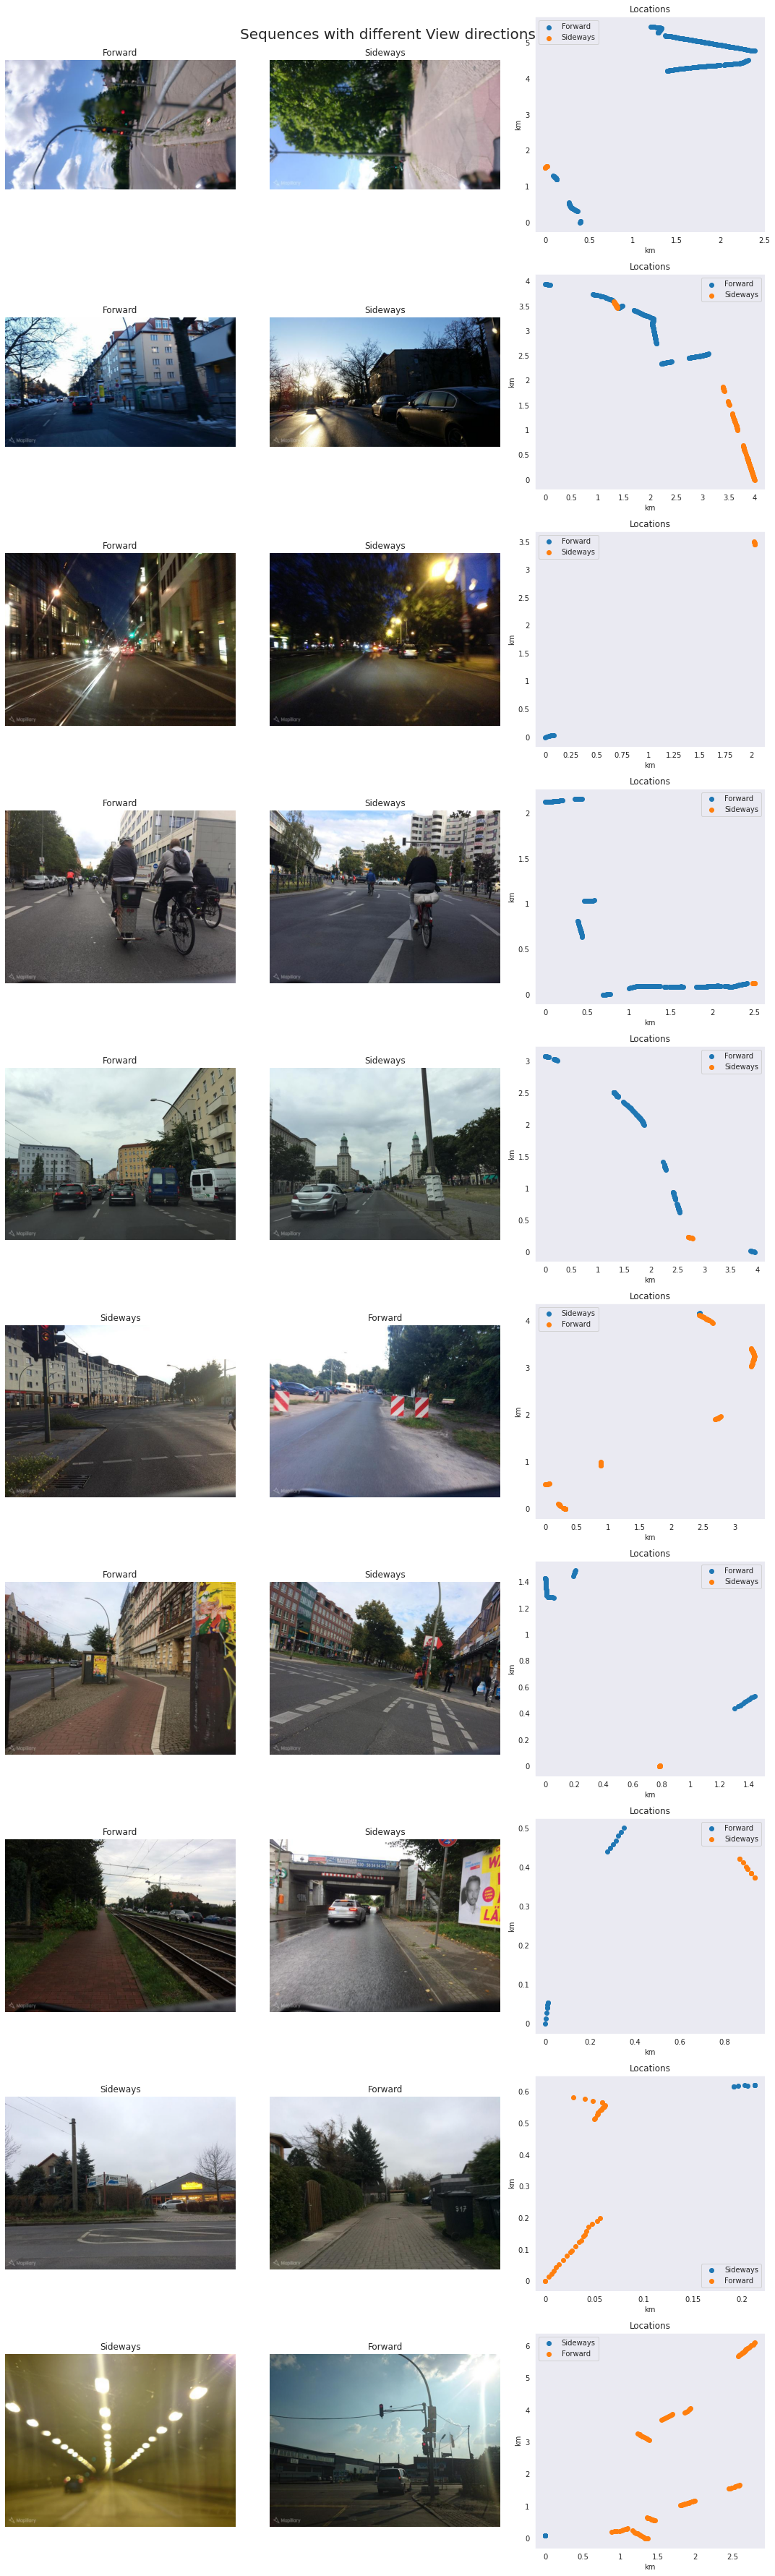

In [5]:
def join_paths(path):
    return "../" +path[0] + "/images/" + path[1] + ".jpg"

def plot_keys(n):

    fig, ax = plt.subplots(n,3,figsize=(15,5*n))

    keys = seq_dif["sequence_key"].unique()

    for i in range(n):

        key = keys[i]

        seq = seq_dif[seq_dif["sequence_key"]==key].copy()
        dirs = seq["view_direction"].unique()
        img1 = join_paths(seq.loc[seq["view_direction"]== dirs[0],["Path","key"]].iloc[0].values)
        img2 = join_paths(seq.loc[seq["view_direction"]== dirs[1],["Path","key"]].iloc[0].values) 

        ax[i,0].imshow(plt.imread(img1))
        ax[i,0].axis('off')
        ax[i,0].set_title(dirs[0])
        ax[i,1].imshow(plt.imread(img2))
        ax[i,1].axis('off')
        ax[i,1].set_title(dirs[1])

        seq.loc[:,"easting"]-=seq["easting"].min()

        seq.loc[:,"northing"]-=seq["northing"].min()
        
        mask1 = seq["view_direction"]== dirs[0]
        mask2 = seq["view_direction"]== dirs[1]


        ax[i,2].scatter(seq.loc[mask1,"easting"],seq.loc[mask1,"northing"],label=dirs[0])
        ax[i,2].scatter(seq.loc[mask2,"easting"],seq.loc[mask2,"northing"],label=dirs[1])
        ax[i,2].legend()
        ax[i,2].set_title("Locations")
        m2km = lambda x, _: f'{x/1000:g}'
        ax[i,2].xaxis.set_major_formatter(m2km)
        ax[i,2].yaxis.set_major_formatter(m2km)
        ax[i,2].set_xlabel("km")
        ax[i,2].set_ylabel("km")


    plt.suptitle("Sequences with different View directions",fontsize = 20)
    plt.tight_layout()
    plt.savefig("Imgs/Sequences with different View directions.jpg")
    plt.show()

plot_keys(10)

In [6]:
wrong_citis = [seq_dif[seq_dif["sequence_key"]==a]["City"].unique() for a in seq_dif["sequence_key"].unique()]
all([len(i)==1 for i in wrong_citis])
## All are in atleast the same city

True

In [7]:
def calcualte_dev_from_center(seq_key):

    seq = seq_dif[seq_dif["sequence_key"]==seq_key].copy()

    seq.loc[:,"easting"]-=seq["easting"].min()

    seq.loc[:,"northing"]-=seq["northing"].min()

    mean_x = seq.loc[:,"easting"].mean()
    mean_y = seq.loc[:,"northing"].mean()

    distances = [np.linalg.norm([mean_x-seq.loc[s,"easting"],mean_y-seq.loc[s,"northing"]]) for s in seq.index]

    return max(distances)

distances = [calcualte_dev_from_center(i) for i in seq_dif["sequence_key"].unique()]

In [8]:
# Trop wrong sequences
df.drop(index=seq_dif.index,inplace=True)

In [9]:
# keys are unique
df.value_counts("key").max()

1

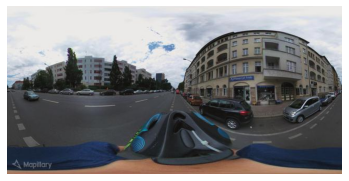

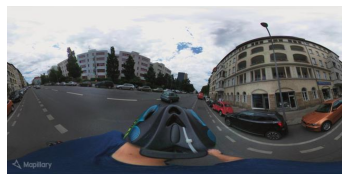

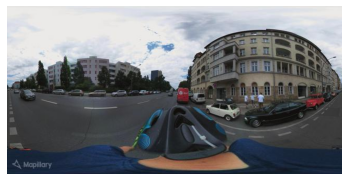

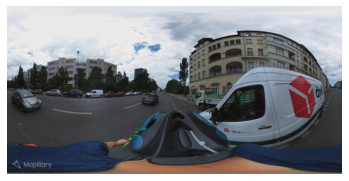

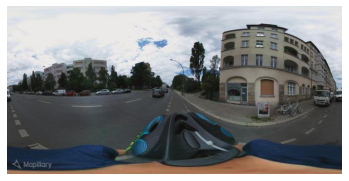

In [10]:
imgs = df[df["pano"]==True]

for i in range(5):

    row = imgs.iloc[i]

    path = f"{row.Path}/images/{row.key}.jpg"

    img = plt.imread("../"+path)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [11]:
# Select images with out pano

df = df[df["pano"]==False]

In [12]:
city = df.groupby(["City"])["view_direction"].count().to_frame()
l = df.value_counts(["City","view_direction"]).to_frame()
def get_values(City):

    df =  l.loc[City].T

    vals = []
    for direction in ["Forward"	,"Sideways"	,"Backward"]:

        if direction in df.columns:
            vals.append(df[direction].values[0])
        else:
            vals.append(0)

    return pd.DataFrame([vals],columns=["Forward"	,"Sideways"	,"Backward"],index=[City])

city = city.join(pd.concat([ get_values(i) for i in city.index]))
city.rename(columns={"view_direction":"image_counts"},inplace=True)
city

,image_counts,Forward,Sideways,Backward
City,,,,
amman,1788,1788,0,0
amsterdam,7196,7070,126,0
austin,42128,37832,1483,2813
bangkok,112119,110610,486,1023
berlin,68325,67552,773,0
boston,20258,20258,0,0
budapest,197633,197347,94,192
cph,16092,15885,207,0
goa,11084,11071,13,0


In [13]:
city[(city.loc[:,["Sideways"	,"Backward"]] > 0).all(axis=1)]

,image_counts,Forward,Sideways,Backward
City,,,,
austin,42128,37832,1483,2813
bangkok,112119,110610,486,1023
budapest,197633,197347,94,192
helsinki,46307,40906,5367,34
melbourne,189945,188821,310,814
moscow,248150,243218,4741,191
ottawa,122624,89818,32756,50
phoenix,151157,145433,1792,3932
sf,10777,9904,520,353


In [14]:
city["image_counts"].sum()

1428894

In [15]:
df.value_counts("view_direction") * 0.1
# We want about 7000 Sideways and 1300 Backward images in our test & val

view_direction
Forward     136558.5
Sideways      5390.7
Backward       940.2
dtype: float64

In [16]:
# this i a good mix
city.loc[["bangkok","helsinki"]].sum()

image_counts    158426
Forward         151516
Sideways          5853
Backward          1057
dtype: int64

In [17]:
# this i a good mix
city.loc[["melbourne","moscow"]].sum()

image_counts    438095
Forward         432039
Sideways          5051
Backward          1005
dtype: int64

In [18]:
val_citys = ["bangkok","helsinki"]
test_citys = ["melbourne","moscow"]
train_citys = city.drop(index=val_citys+test_citys).index.values

train_df_all = df.loc[df["City"].apply(lambda x: x in train_citys)]
test_df_all = df.loc[df["City"].apply(lambda x: x in test_citys)]
val_df_all = df.loc[df["City"].apply(lambda x: x in val_citys)]

In [19]:
782030 -  730000

52030

In [20]:
train_df_all.value_counts("view_direction")

view_direction
Forward     782030
Sideways     43003
Backward      7340
dtype: int64

In [21]:
151516 - 140000

11516

In [22]:
val_df_all.value_counts("view_direction")
# we can drop about 900000 forward images in train and 35000 in train and test

view_direction
Forward     151516
Sideways      5853
Backward      1057
dtype: int64

In [23]:
test_df_all.value_counts("view_direction")
# we can drop about 900000 forward images in train and 35000 in train and test

view_direction
Forward     432039
Sideways      5051
Backward      1005
dtype: int64

In [24]:
def drop_n_forward(df,n):

    df = df.copy()
    indeces = df[df["view_direction"] == "Forward"].index
    keep = np.random.choice(indeces,len(indeces)-n,replace = False)
    indices_to_keep = np.concatenate([keep, df[df["view_direction"] != "Forward"].index])
    return df.loc[indices_to_keep].copy()
train_df = drop_n_forward(train_df_all,700000)
val_df = drop_n_forward(val_df_all,140000)
test_df = drop_n_forward(test_df_all,422000)

In [25]:
train_df.value_counts("view_direction")

view_direction
Forward     82030
Sideways    43003
Backward     7340
dtype: int64

In [26]:
val_df.value_counts("view_direction")

view_direction
Forward     11516
Sideways     5853
Backward     1057
dtype: int64

In [27]:
test_df.value_counts("view_direction")

view_direction
Forward     10039
Sideways     5051
Backward     1005
dtype: int64

In [28]:

# shuffle ds 
train_df = train_df.sample(frac = 1, random_state= 1)



train_df["ds_type"] = "train"
val_df["ds_type"] = "val"
test_df["ds_type"] = "test"

In [29]:
df = pd.concat([train_df,val_df,test_df])
df.drop(columns=["Unnamed: 0_x","unique_cluster","pano","Unnamed: 0_y","frame_number","control_panel","night"],inplace=True)
df.index = range(len(df))
df.to_csv("view_directions_data.csv")

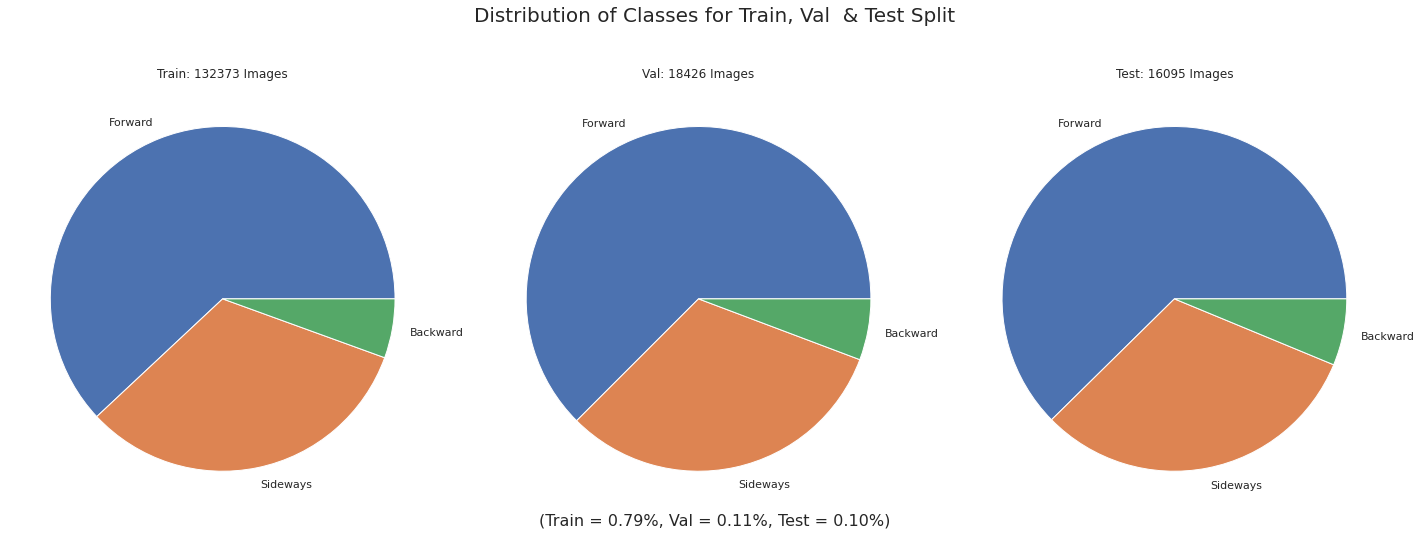

In [30]:
sns.set_theme()
def plot_pie(df,ax):

    x = df["view_direction"].value_counts()

    ax.pie(x.values,labels = x.index )

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Images')
ax[1].title.set_text(f'Val: {len(val_df)} Images')
ax[2].title.set_text(f'Test: {len(test_df)} Images')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1])
plot_pie(test_df,ax[2])
plt.suptitle(f"Distribution of Classes for Train, Val  & Test Split",fontsize=20)
plt.tight_layout()
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(df):.2f}%, Val = {len(val_df)/len(df):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
plt.savefig("Imgs/Training Split.jpg")
plt.show()

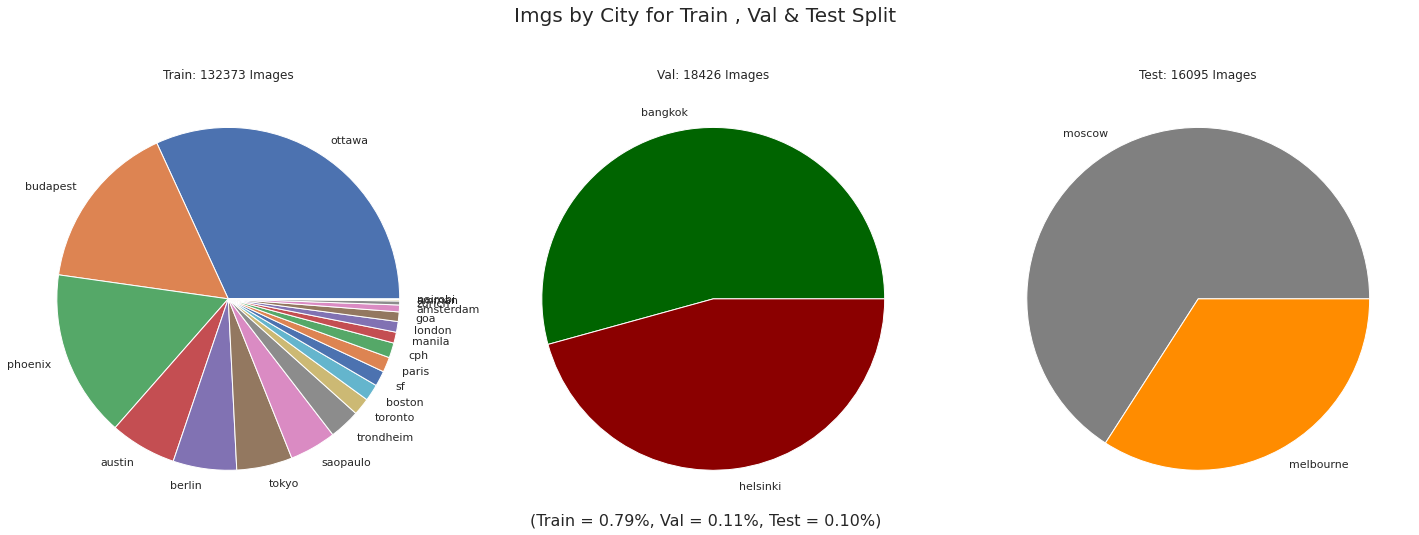

In [31]:
def plot_pie(df,ax,colors = None):

    x = df["City"].value_counts()

    ax.pie(x.values,labels = x.index ,colors = colors)

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Images')
ax[1].title.set_text(f'Val: {len(val_df)} Images')
ax[2].title.set_text(f'Test: {len(test_df)} Images')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1],colors=["darkgreen","darkred"])
plot_pie(test_df,ax[2],colors=["grey","darkorange"])
plt.suptitle(f"Imgs by City for Train , Val & Test Split", fontsize=20)
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(df):.2f}%, Val = {len(val_df)/len(df):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
plt.tight_layout()
plt.savefig("Imgs/Citys Split.jpg")
plt.show()